In [4]:
pwd

'/Users/xuyang/Downloads/kaggle'

# 数据写入和查看


In [31]:
import pandas as pd
training_data = pd.read_csv('GiveMeSomeCredit/cs-training.csv', index_col = [0])
#翻译一下
"""
column={'ID':'用户ID',
        'SeriousDlqin2yrs':'好坏客户',
        'RevolvingUtilizationOfUnsecuredLines':'可用额度比值',
        'age':'年龄',
        'NumberOfTime30-59DaysPastDueNotWorse':'逾期30-59天笔数',
        'DebtRatio':'负债率',
        'MonthlyIncome':'月收入',
        'NumberOfOpenCreditLinesAndLoans':'信贷数量',
        'NumberOfTimes90DaysLate':'逾期90天笔数',
        'NumberRealEstateLoansOrLines':'固定资产贷款量',
        'NumberOfTime60-89DaysPastDueNotWorse':'逾期60-89天笔数',
        'NumberOfDependents':'家属数量'}
training_data.rename(columns=column,inplace=True)
"""
training_data.head()

#查看数据类型和缺失值， 数据维度， label分布
training_data.shape
training_data.info()
training_data['SeriousDlqin2yrs'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

# 特征工程


## 去重

In [32]:
training_data.drop_duplicates(inplace = True) # 原地丢弃
training_data.index = range(training_data.shape[0])
training_data.shape

(149391, 11)

In [33]:
training_data.info() #可知月收入和家属数量有缺失值
training_data.isnull().mean()#月收入20%缺失值，家属数量2.5%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         120170 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    145563 non-null  float64
dtype

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

## 处理缺失值

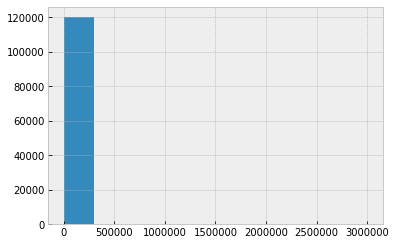

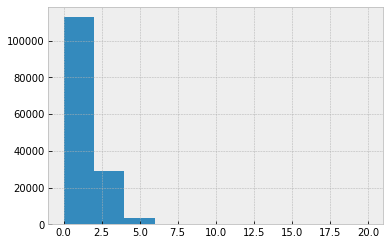

In [34]:
# 查看缺失值分布形态
import matplotlib.pyplot as plt
null_list=['MonthlyIncome','NumberOfDependents']
for col in null_list:
    plt.style.use('bmh')
    plt.hist(training_data[col].dropna().values)
    plt.show()

In [35]:
#类似于正态分布，对家属数量填充中位数
training_data['NumberOfDependents'].fillna(training_data['NumberOfDependents'].median(), inplace = True)

In [36]:
#月收入由于缺失值较多，随即森林填充法
def fill_missing_rf(X, y, to_fill):
    """
    参数：
    X: 特征矩阵
    y: 标签
    to_fill:要填补的特征的名称
    """
    df = X.copy()
    fill = df.loc[:, to_fill]
    #除掉要填补的那一列，与标签concate
    df = pd.concat([df.loc[:, df.columns!=to_fill], pd.DataFrame(y)], axis = 1)
    
    #split training and predicting dataset
    Ytrain = fill[fill.notnull()]
    Ytest = fill[fill.isnull()]
    Xtrain = df.iloc[Ytrain.index, :]
    Xtest = df.iloc[Ytest.index, :]
    
    from sklearn.ensemble import RandomForestRegressor as rfr
    rfr = rfr(n_estimators = 100)
    rfr = rfr.fit(Xtrain, Ytrain)
    return rfr.predict(Xtest)
    

In [37]:
X = training_data.iloc[:, 1:]
y = training_data['SeriousDlqin2yrs']
y_pred = fill_missing_rf(X, y, 'MonthlyIncome')
y_pred
training_data.loc[training_data.loc[:, 'MonthlyIncome'].isnull(), 'MonthlyIncome'] = y_pred

In [38]:
training_data.info() #缺失值处理完成

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         149391 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    149391 non-null  float64
dtype

## 异常值处理

In [39]:
training_data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000,1.493910e+05,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000
mean,0.066999,6.071087,52.306237,0.393886,354.436740,5.424938e+03,8.480892,0.238120,1.022391,0.212503,0.740393
std,0.250021,250.263672,14.725962,3.852953,2041.843455,1.323963e+04,5.136515,3.826165,1.130196,3.810523,1.108272
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030132,41.000000,0.000000,0.177441,1.800000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154235,52.000000,0.000000,0.368234,4.419000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.556494,63.000000,0.000000,0.875279,7.416000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [40]:
#年龄最小为0 -> 信用卡最小办理年纪是18岁 删除数据

training_data = training_data[training_data['age']>=18]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdd5dc26190>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdd5dc657d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdd5dc600d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fdd5dc60e10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fdd5dc6b750>,
 'means': []}

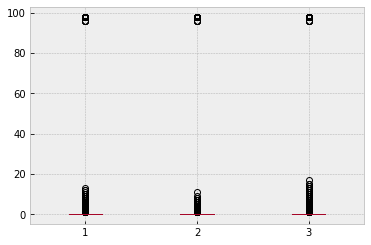

In [41]:
#箱型图
plt.boxplot([training_data['NumberOfTime30-59DaysPastDueNotWorse'], training_data['NumberOfTime60-89DaysPastDueNotWorse'], training_data['NumberOfTimes90DaysLate']])

In [42]:
#看是不是同一行
training_data[(training_data['NumberOfTimes90DaysLate']>90) & (training_data['NumberOfTime60-89DaysPastDueNotWorse']>90) & (training_data['NumberOfTime30-59DaysPastDueNotWorse']>90)].shape
training_data[training_data['NumberOfTimes90DaysLate']>90].shape
#确定是同一行 删除
training_data = training_data[training_data.loc[:, 'NumberOfTimes90DaysLate']<90]

## 样本不平衡

In [43]:
#查看标签分布
import numpy as np
np.unique(training_data['SeriousDlqin2yrs'],return_counts = True)

(array([0, 1]), array([139292,   9873]))

In [44]:
#SMOTE上采样->对少数样本中的某一样本和邻近点的连线中采样
import imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 404)
X, y = smote.fit_resample(training_data.iloc[:,1:], training_data.iloc[:, 0])

In [48]:
np.unique(y, return_counts = True)
y = np.array(y).reshape(-1, 1)
data = np.concatenate((y, X), axis = 1)
train_data = pd.DataFrame(data, columns = training_data.columns)


In [96]:
train_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1.0,0.766127,45.0,2.0,0.802982,9120.0,13.0,0.0,6.0,0.0,2.0
1,0.0,0.957151,40.0,0.0,0.121876,2600.0,4.0,0.0,0.0,0.0,1.0
2,0.0,0.658180,38.0,1.0,0.085113,3042.0,2.0,1.0,0.0,0.0,0.0
3,0.0,0.233810,30.0,0.0,0.036050,3300.0,5.0,0.0,0.0,0.0,0.0
4,0.0,0.907239,49.0,1.0,0.024926,63588.0,7.0,0.0,1.0,0.0,0.0


In [97]:
train_data['AllNumlate']=train_data['NumberOfTime30-59DaysPastDueNotWorse']+train_data['NumberOfTime60-89DaysPastDueNotWorse']+train_data['NumberOfTimes90DaysLate']
train_data['Monthlypayment']=train_data['DebtRatio']*train_data['MonthlyIncome']

## 分箱

In [98]:
from sklearn.tree import DecisionTreeClassifier
def optimal_binning_boundary(x: pd.Series, y: pd.Series, nan: float = -999.):
    '''
        利用决策树获得最优分箱的边界值列表
    '''
    boundary = []  # 待return的分箱边界值列表
    
    x = x.fillna(nan).values  # 填充缺失值
    y = y.values
    
    clf = DecisionTreeClassifier(criterion='entropy',    #“信息熵”最小化准则划分
                                 max_leaf_nodes=6,       # 最大叶子节点数
                                 min_samples_leaf=0.05)  # 叶子节点样本数量最小占比

    clf.fit(x.reshape(-1, 1), y)  # 训练决策树
    
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    threshold = clf.tree_.threshold
    
    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  # 获得决策树节点上的划分边界值
            boundary.append(threshold[i])

    boundary.sort()

    min_x = x.min()
    max_x = x.max() + 0.1  # +0.1是为了考虑后续groupby操作时，能包含特征最大值的样本
    boundary = [min_x] + boundary + [max_x]

    return boundary

def feature_woe_iv(x: pd.Series, y: pd.Series, nan: float = -999.) -> pd.DataFrame:
    '''
        计算变量各个分箱的WOE、IV值，返回一个DataFrame
    '''
    x = x.fillna(nan)
    boundary = optimal_binning_boundary(x, y, nan)        # 获得最优分箱边界值列表
    df = pd.concat([x, y], axis=1)                        # 合并x、y为一个DataFrame，方便后续计算
    df.columns = ['x', 'y']                               # 特征变量、目标变量字段的重命名
    df['bins'] = pd.cut(x=x, bins=boundary, right=False)  # 获得每个x值所在的分箱区间
    
    grouped = df.groupby('bins')['y']                     # 统计各分箱区间的好、坏、总客户数量
    result_df = grouped.agg([('good',  lambda y: (y == 0).sum()), 
                             ('bad',   lambda y: (y == 1).sum()),
                             ('total', 'count')])

    result_df['good_pct'] = result_df['good'] / result_df['good'].sum()       # 好客户占比
    result_df['bad_pct'] = result_df['bad'] / result_df['bad'].sum()          # 坏客户占比
    result_df['total_pct'] = result_df['total'] / result_df['total'].sum()    # 总客户占比

    result_df['bad_rate'] = result_df['bad'] / result_df['total']             # 坏比率
    
    result_df['woe'] = np.log(result_df['good_pct'] / result_df['bad_pct'])              # WOE
    result_df['iv'] = (result_df['good_pct'] - result_df['bad_pct']) * result_df['woe']  # IV
    
    return result_df

In [99]:
train_data.keys()[1:]
IV_values = {}
woe_values = {}
bins_values = {}
for key in train_data.keys()[1:]:
    IV_values[key] = feature_woe_iv(train_data[key], train_data[train_data.keys()[0]])['iv'].sum()
    bins_values[key] = 
IV_values

该变量IV = 1.6187230614722146
该变量IV = 0.35213317216780615
该变量IV = 0.38950655287428143
该变量IV = 0.1571174241083306
该变量IV = 0.15103895469407821
该变量IV = 0.07865895630604257
该变量IV = 0.45592649500795723
该变量IV = 0.150970721201119
该变量IV = 0.18307789966184482
该变量IV = inf


/Users/xuyang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


该变量IV = 0.7508992800410031
该变量IV = 0.21302564306986432


{'RevolvingUtilizationOfUnsecuredLines': 1.6187230614722146,
 'age': 0.35213317216780615,
 'NumberOfTime30-59DaysPastDueNotWorse': 0.38950655287428143,
 'DebtRatio': 0.1571174241083306,
 'MonthlyIncome': 0.15103895469407821,
 'NumberOfOpenCreditLinesAndLoans': 0.07865895630604257,
 'NumberOfTimes90DaysLate': 0.45592649500795723,
 'NumberRealEstateLoansOrLines': 0.150970721201119,
 'NumberOfTime60-89DaysPastDueNotWorse': 0.18307789966184482,
 'NumberOfDependents': inf,
 'AllNumlate': 0.7508992800410031,
 'Monthlypayment': 0.21302564306986432}

In [114]:
def to_woe_value(train_data, feature):
    woe_df = feature_woe_iv(x = train_data[feature], y = train_data['SeriousDlqin2yrs'])['woe']
    def get_woe(x):
        for bin, woe in woe_df.iteritems():
            if bin.left <= x < bin.right:
                return woe
    woe_series = train_data[feature].apply(get_woe)
    return woe_series

In [ ]:
train_data = train_data.drop('NumberOfDependents', axis = 1)

In [125]:
woe_data = train_data.copy()
for key in train_data.keys()[1:]:
    woe_data[key]= to_woe_value(key)

该变量IV = 1.6187230614722146
该变量IV = 0.35213317216780615
该变量IV = 0.38950655287428143
该变量IV = 0.1571174241083306
该变量IV = 0.15103895469407821
该变量IV = 0.07865895630604257
该变量IV = 0.45592649500795723
该变量IV = 0.150970721201119
该变量IV = 0.18307789966184482
该变量IV = 0.7508992800410031
该变量IV = 0.21302564306986432


In [128]:
woe_data.to_csv('GiveMeSomeCredit/WoeData.csv', encoding='utf8', index=False)

In [179]:
X = woe_data.iloc[:, 1:]
Y = woe_data.iloc[:, 0]

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1221)

## 逻辑回归

In [171]:
#直接调用sklearn中Logistic模型
from sklearn.linear_model import LogisticRegressionCV as LR
from sklearn.metrics import roc_curve,roc_auc_score

#定义一个画ROC曲线的函数
def plot_roc_curve(fpr,tpr):
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], "k--")
    plt.xlabel('fpr')
    plt.ylabel('tpr')

lr = LR(solver="liblinear") 
results=lr.fit(X_train,y_train)
lr_predict_proba =  lr.predict_proba(X_test)


## 随机森林

In [144]:
#建立RandomForest模型
from sklearn.ensemble import RandomForestClassifier as RFC
#训练
rf = RFC(
    n_estimators=700, 
    criterion='gini', 
    max_depth=5, 
    max_features='auto', 
    min_impurity_decrease=0.01, 
    n_jobs=2, 
    random_state=10, 
    )

rf.fit(X_train,y_train)
rf_predict_proba = rf.predict_proba(X_test)
rf_def_rate = rf_predict_proba[:,1]

/Users/xuyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


## XGBoost

In [180]:
from xgboost import XGBClassifier as XGB
#建模：
xgb = XGB(
    max_depth=3, 
    learning_rate=0.1, 
    n_estimators=100, 
    n_jobs=2, 
    random_state=22, 
    seed=11)

xgb.fit(X_train,y_train)
xgb_predict_proba = xgb.predict_proba(X_test)
xgb_def_rate = xgb_predict_proba[:,1]

/Users/xuyang/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [154]:
def visualize_ROC(y_test, def_rate):
#计算AUC值
    fpr, tpr, thresh_lr = roc_curve(y_test,def_rate)
    plot_roc_curve(fpr,tpr)
    print('AUC = {}'.format(roc_auc_score(y_test,def_rate)))

AUC = 0.874442228461746


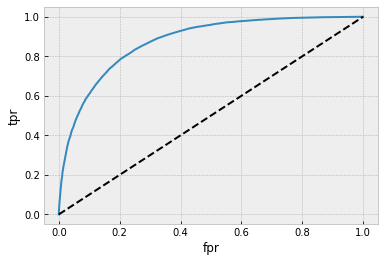

In [183]:
visualize_ROC(y_test, xgb_def_rate)

## 评估 

In [ ]:
# CV调参数 TODO